In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))

import torch
import numpy as np
import torch.nn as nn
from matplotlib import pyplot as plt
from trajectories import TrajectoriesDataset, preprocess_dataset, find_activations
from torch.utils.data import DataLoader
from reward_predictor import RewardPredictor
from train_reward_predictor import evaluate


In [2]:
from train_reward_predictor import PAD_VAL, ACTION_SPACE_SIZE, OBSERVATION_SPACE_DIMS
BATCH_SIZE = 128
ATTENTION_THRESHOLD = 0.2
EVALUATION_DIR = './ca-evaluation-3x3'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_path = os.path.join(EVALUATION_DIR, 'trajectories_ep15000_dur36.20_ret0.52_5K.pt')
dataset = torch.load(data_path)

# global variables used in other parts
seq_len = dataset.observations.shape[1]
criterion = nn.CrossEntropyLoss(ignore_index=PAD_VAL) # will be ignored
timing = dict() # will be ignored

# credit assignment ground truths
trigger_activations = find_activations(dataset.observations, dataset.actions, target='trigger').to(device) # N, S
prize_activations = find_activations(dataset.observations, dataset.actions, target='prize') # N, S
trigger_activations_indices = torch.argmax(trigger_activations, axis=-1).to(device) # (N,) timesteps preceding trigger activation
prize_activations_indices = torch.argmax(prize_activations, axis=-1) # (N,) timesteps preceding taking prize 

episodes_with_prize_mask = torch.sum(prize_activations, axis=-1).to(device) # mask for episodes where prizes were taken
episodes_with_trigger_mask = torch.sum(trigger_activations, axis=-1).to(device)  # (N, )

ca_gt = {
    'attention_threshold': ATTENTION_THRESHOLD,
    'batch_size': BATCH_SIZE,
    'episodes_with_trigger_mask': episodes_with_trigger_mask,
    'episodes_with_prize_mask': episodes_with_prize_mask,
    'seq_len': seq_len,
    'trigger_activations': trigger_activations,
    'trigger_timesteps': trigger_activations_indices,
    'prize_activations': prize_activations,
    'prize_timesteps': prize_activations_indices,
}

# find all models for evaluation
models = []
for root, _, dirs in os.walk(EVALUATION_DIR):
    for path in dirs:
        if 'model' not in path:
            continue
        models.append(os.path.join(root,path))

In [3]:
path_to_mean = '../trajectories/ep15000_dur36.20_ret0.52/trajectories/10.00K_mean_s42.pt' # computed on the train set
path_to_std = '../trajectories/ep15000_dur36.20_ret0.52/trajectories/10.00K_std_s42.pt' # computed on the train set
data_loader = preprocess_dataset(dataset, data_path, sum_rewards=True, normalize=True, 
                                 eval_mode=True, path_to_mean=path_to_mean, path_to_std=path_to_std)

accs = []
ca_precisions = []
ca_recalls = []

for model_path in models:
    model = torch.load(model_path).to(device)
    attention_weights_global = torch.zeros((BATCH_SIZE, seq_len*2+1), device=device) # N, S*2

    _, acc, ca_precision, ca_recall, rel_attention_vals = evaluate(model, criterion, data_loader, device, timing, ca_gt)

    accs.append(acc)
    ca_precisions.append(ca_precision)
    ca_recalls.append(ca_recall)
    # break

acc_mean, acc_std = torch.mean(torch.tensor(accs)), torch.std(torch.tensor(accs))
precision_mean, precision_std = torch.mean(torch.tensor(ca_precisions)), torch.std(torch.tensor(ca_precisions))
recall_mean, recall_std = torch.mean(torch.tensor(ca_recalls)), torch.std(torch.tensor(ca_recalls))

print(f'Accuracy (reward prediction): {acc_mean:.3f} ±{acc_std:.3f}')
print(f'Precision (credit assignment): {precision_mean:.3f} ±{precision_std:.3f}')
print(f'Recall (credit assignment): {recall_mean:.3f} ±{recall_std:.3f}')
    

/home/mbaliesnyi/anaconda3/envs/rl/lib/python3.8/site-packages/torch/tensor.py:758: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:930.)
  return super(Tensor, self).refine_names(names)
Accuracy (reward prediction): 0.814 ±0.038
Precision (credit assignment): 0.994 ±0.004
Recall (credit assignment): 0.996 ±0.003


## Attention plot

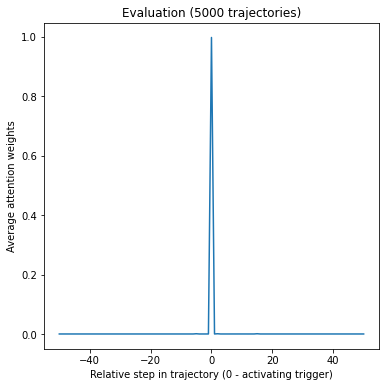

In [4]:
fig, axes = plt.subplots(1, 1, figsize=(6,6))
x_axis = (torch.arange(rel_attention_vals.shape[0]) - seq_len).cpu()

axes.set_title('Evaluation (5000 trajectories)')
axes.set_xlabel('Relative step in trajectory (0 - activating trigger)')
axes.set_ylabel('Average attention weights')
axes.plot(x_axis, rel_attention_vals.cpu())

plt.show()